Ensuring a clean installation of numpy and pmdarima...
Found existing installation: pmdarima 2.0.4
Uninstalling pmdarima-2.0.4:
  Successfully uninstalled pmdarima-2.0.4
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opencv-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-contrib-python 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you have numpy 1.26.4 which is incompatible.
opencv-python-headless 4.12.0.88 requires numpy<2.3.0,>=2; python_version >= "3.9", but you

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)



Mounting Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Data loaded successfully from Google Drive.

Splitting data into training and testing sets...
Training data size: 2140 samples
Testing data size: 395 samples


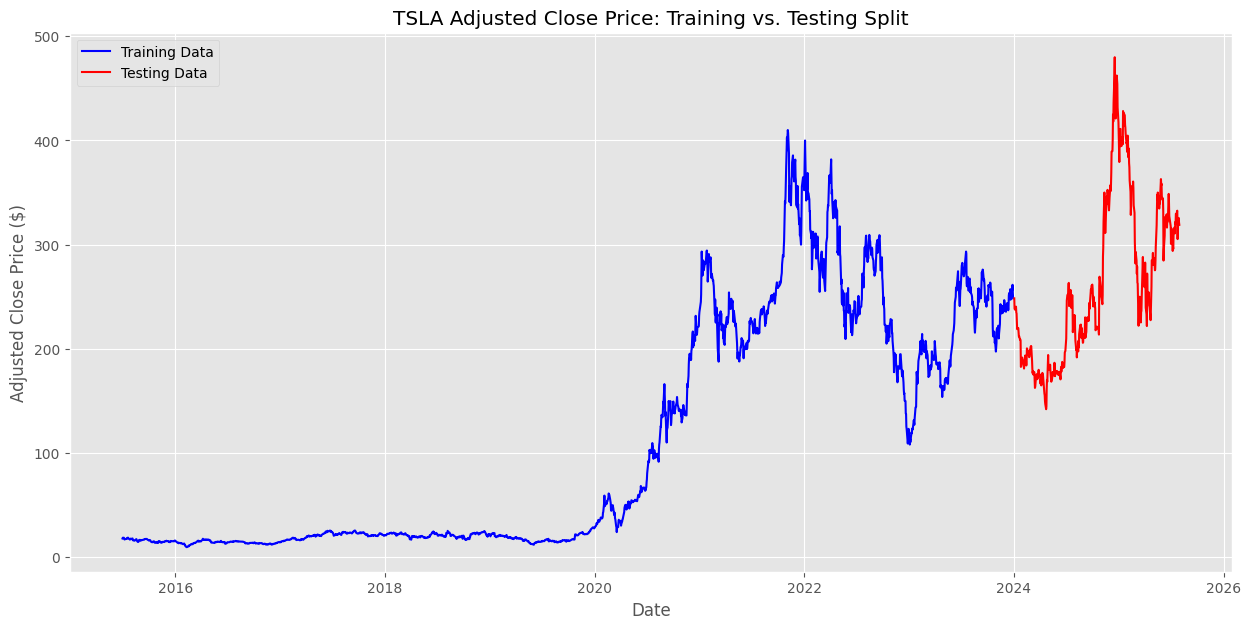


Finding optimal ARIMA parameters with auto_arima...
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=13648.219, Time=0.99 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=13647.752, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=13647.771, Time=0.20 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=13647.825, Time=0.29 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=13646.472, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.645 seconds

Best ARIMA model parameters found:
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2140
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -6822.236
Date:                Tue, 12 Aug 2025   AIC                          13646.472
Time:                        12:42:04   BIC                          13652.140
Sample:                             0   HQIC                 

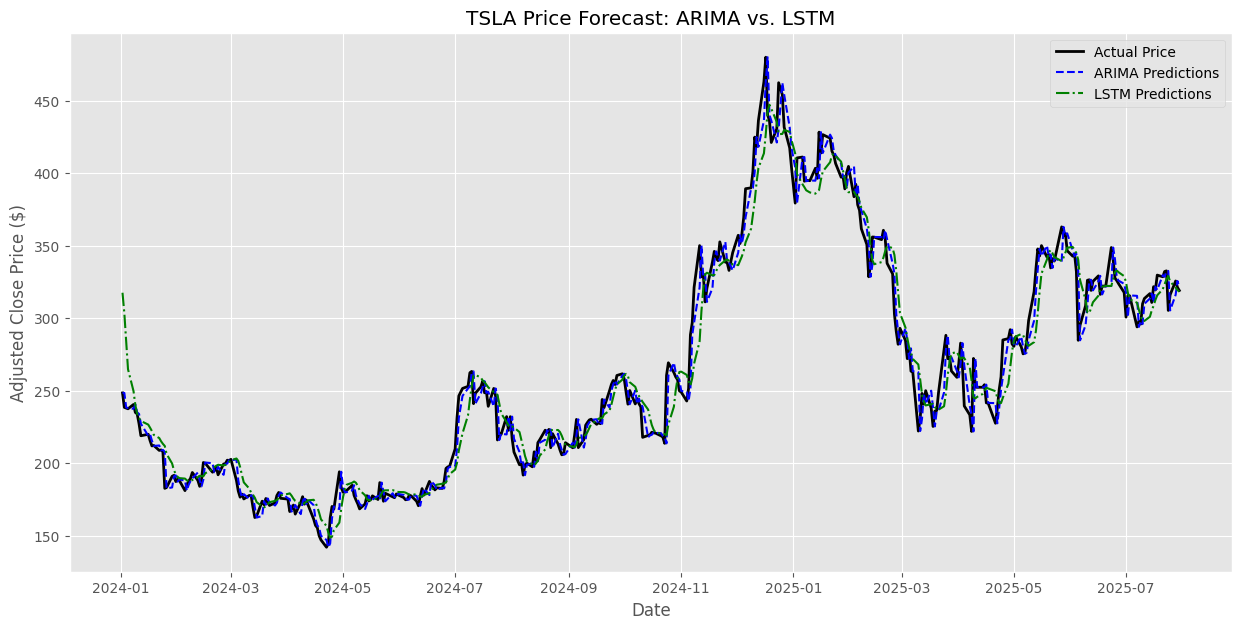

In [3]:
# --- IMPORTANT: Clean installation steps for libraries ---
# This new, more robust approach first uninstalls everything, then installs
# a specific version of numpy that is compatible with both Python 3.11
# and TensorFlow, and finally installs the latest pmdarima version.
print("Ensuring a clean installation of numpy and pmdarima...")
!pip uninstall -y pmdarima numpy
!pip install numpy==1.26.4
!pip install pmdarima

# Now, we can proceed with the rest of the code.

# Import all necessary libraries.
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pmdarima as pm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import warnings
from google.colab import drive

# Filter out future warnings for a cleaner output
warnings.filterwarnings("ignore")

# Set plot style for better visuals
plt.style.use('ggplot')

# --- Step 1: Mount Google Drive and Load Data ---
# This is a crucial step to access your data from Google Drive.
print("\nMounting Google Drive...")
drive.mount('/content/drive')

# Define the path to your data file in Google Drive.
# **IMPORTANT**: You need to change this path to where your file is located.
# For example, if your file is in 'My Drive/10academy/data/', the path would be:
# /content/drive/MyDrive/10academy/data/financial_data_raw.csv
data_path = '/content/drive/MyDrive/financial_data_raw.csv'

# Now, load the data directly from Google Drive
try:
    adj_close_data = pd.read_csv(
        data_path,
        index_col=0,
        parse_dates=True
    )['TSLA'].to_frame()
    print("Data loaded successfully from Google Drive.")
except FileNotFoundError:
    print(f"Error: The file '{data_path}' was not found. Please verify the path to your CSV file in Google Drive and update the 'data_path' variable.")
    adj_close_data = pd.DataFrame() # Create an empty DataFrame to avoid errors


if not adj_close_data.empty:
    # --- Step 2: Data Splitting ---
    print("\nSplitting data into training and testing sets...")
    # Define the split date
    split_date = '2024-01-01'

    # Split the data into training and testing sets
    train_data = adj_close_data[adj_close_data.index < split_date]
    test_data = adj_close_data[adj_close_data.index >= split_date]

    print(f"Training data size: {len(train_data)} samples")
    print(f"Testing data size: {len(test_data)} samples")

    # Plot the split
    plt.figure(figsize=(15, 7))
    plt.plot(train_data['TSLA'], label='Training Data', color='blue')
    plt.plot(test_data['TSLA'], label='Testing Data', color='red')
    plt.title('TSLA Adjusted Close Price: Training vs. Testing Split')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()

    # --- Step 3: ARIMA Model Development and Forecasting ---
    # Use auto_arima to find the best (p, d, q) parameters
    print("\nFinding optimal ARIMA parameters with auto_arima...")
    arima_model = pm.auto_arima(
        train_data['TSLA'],
        start_p=1, start_q=1,
        test='adf',  # Use ADF test to find optimal 'd'
        max_p=5, max_q=5,
        m=1, # Non-seasonal
        d=None, # Let auto_arima determine 'd'
        trace=True,
        error_action='ignore',
        suppress_warnings=True,
        stepwise=True
    )

    print("\nBest ARIMA model parameters found:")
    print(arima_model.summary())

    # Create a list to store predictions
    arima_predictions = []
    # Create a local copy of the training data as a numpy array
    rolling_train_values = train_data['TSLA'].values

    # Make predictions for the test set period
    for t in range(len(test_data)):
        # Re-train the model with expanding window of training data.
        # This simulates a real-world scenario where the model is updated daily.
        model = ARIMA(rolling_train_values, order=arima_model.order)
        model_fit = model.fit()
        prediction = model_fit.forecast(steps=1)[0]
        arima_predictions.append(prediction)

        # Add the test data point to the training data for the next prediction
        rolling_train_values = np.append(rolling_train_values, test_data['TSLA'].iloc[t])

    # Convert the list of predictions to a pandas Series
    arima_predictions = pd.Series(arima_predictions, index=test_data.index)


    # --- Step 4: LSTM Model Development and Forecasting (Revised) ---
    print("\nBuilding and training LSTM model...")
    # Data preparation for LSTM
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(adj_close_data)

    def create_sequences_for_training(data, look_back):
        X, y = [], []
        for i in range(len(data) - look_back - 1):
            X.append(data[i:(i + look_back), 0])
            y.append(data[i + look_back, 0])
        return np.array(X), np.array(y)

    look_back = 60
    # Prepare training data from the scaled data
    scaled_train_data = scaled_data[:len(train_data)]
    X_train, y_train = create_sequences_for_training(scaled_train_data, look_back)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=25))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    # Note: Training LSTMs can take a few minutes in Colab
    model.fit(X_train, y_train, epochs=25, batch_size=32, verbose=1)

    # --- New Rolling Forecast for LSTM ---
    lstm_predictions = []
    # Get the last 'look_back' values from the training set to start the forecast
    last_60_days = adj_close_data['TSLA'].values[-look_back:]
    rolling_test_data = last_60_days

    # Loop through the test data and make predictions one day at a time
    for i in range(len(test_data)):
        # Reshape the data for the LSTM model
        X_input = scaler.transform(rolling_test_data.reshape(-1, 1))
        X_input = X_input.reshape((1, look_back, 1))

        # Predict the next day's price
        predicted_price_scaled = model.predict(X_input, verbose=0)
        predicted_price = scaler.inverse_transform(predicted_price_scaled)[0][0]
        lstm_predictions.append(predicted_price)

        # Update the rolling test data with the actual price from the test set
        rolling_test_data = np.append(rolling_test_data[1:], test_data['TSLA'].iloc[i])

    # Convert the list of predictions to a pandas Series
    lstm_predictions = pd.Series(lstm_predictions, index=test_data.index)


    # --- Step 5: Performance Evaluation and Comparison ---
    # Calculate evaluation metrics for ARIMA
    mae_arima = mean_absolute_error(test_data['TSLA'], arima_predictions)
    rmse_arima = np.sqrt(mean_squared_error(test_data['TSLA'], arima_predictions))
    mape_arima = np.mean(np.abs((test_data['TSLA'] - arima_predictions) / test_data['TSLA'])) * 100

    # Calculate evaluation metrics for LSTM
    mae_lstm = mean_absolute_error(test_data['TSLA'], lstm_predictions)
    rmse_lstm = np.sqrt(mean_squared_error(test_data['TSLA'], lstm_predictions))
    mape_lstm = np.mean(np.abs((test_data['TSLA'] - lstm_predictions) / test_data['TSLA'])) * 100

    # Print the results
    print("\n--- Model Performance Comparison ---")
    print(f"ARIMA MAE: {mae_arima:.2f}")
    print(f"ARIMA RMSE: {rmse_arima:.2f}")
    print(f"ARIMA MAPE: {mape_arima:.2f}%")

    print(f"\nLSTM MAE: {mae_lstm:.2f}")
    print(f"LSTM RMSE: {rmse_lstm:.2f}")
    print(f"LSTM MAPE: {mape_lstm:.2f}%")

    # Visualize the results
    plt.figure(figsize=(15, 7))
    plt.plot(test_data['TSLA'], label='Actual Price', color='black', linewidth=2)
    plt.plot(arima_predictions, label='ARIMA Predictions', color='blue', linestyle='--')
    plt.plot(lstm_predictions, label='LSTM Predictions', color='green', linestyle='-.')
    plt.title('TSLA Price Forecast: ARIMA vs. LSTM')
    plt.xlabel('Date')
    plt.ylabel('Adjusted Close Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
